In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import time

# global parameters - you can change these
discount=1.0
startepsilon=0.5
baseepsilon=0.01
alpha=0.01

# suggested values - you can change these
learnEpisodes=60000
evaluationEpisodes=100 # CartPole
evaluationEpisodes=500 # Frozen and Lunar



np.random.seed(5467)

# Please use the given Enviroment interface
# which returns
# env = env handle
# dim=dimension of phi(s)
# nA = number of actions
# phi() = state representation
# dname = enviroment name 

def sigmoid(x):
        return 1/(1 + np.exp(-x))

def frozenPhi8(s):
    a=np.zeros(64)
    a[s]=1.0
    return(a)

def prepFrozen8():
    dname="Frozen8"
    env = gym.make('FrozenLake-v0',desc=None,map_name=None)
    env.seed(48304)
    nA=env.nA
    dim=64
    mymaxsteps=1000
    env._max_episode_steps = mymaxsteps
    return(env,dim,nA,frozenPhi8,dname)

# Cart Pole
#Observation: 
#        Type: Box(4)
#        Num	Observation                 Min         Max
#        0	Cart Position             -4.8            4.8
#        1	Cart Velocity             -Inf            Inf
#        2	Pole Angle                 -24 deg        24 deg
#        3	Pole Velocity At Tip      -Inf            Inf
        
#    Actions:
#        Type: Discrete(2)
#        Num	Action
#        0	Push cart to the left
#        1	Push cart to the right

def identity(x):
    return x

def prepCartPole():
    env = gym.make('CartPole-v0')
    dname="CartPole"
    env.seed(48304)
    dim=np.shape(env.observation_space)[0]
    nA=env.action_space.n
    env._max_episode_steps = 500
    return(env,dim,nA,identity,dname)

#LunarLander-v2 4 actions
# Nop, fire left engine, main engine, right engine
#self.action_space = spaces.Discrete(4)

# LunarLander: code from state transition gives semantics of state variables
# state
#(pos.x - VIEWPORT_W/SCALE/2) / (VIEWPORT_W/SCALE/2),
#(pos.y - (self.helipad_y+LEG_DOWN/SCALE)) / (VIEWPORT_H/SCALE/2),
#vel.x*(VIEWPORT_W/SCALE/2)/FPS,
#vel.y*(VIEWPORT_H/SCALE/2)/FPS,
#self.lander.angle,
#20.0*self.lander.angularVelocity/FPS,
#1.0 if self.legs[0].ground_contact else 0.0,
#1.0 if self.legs[1].ground_contact else 0.0
#]

# phi() allows non-linear dependence through added components
def LunarPhi(s):
    x,y,vx,vy,a,va,ll,lr=s
    #return(sigmoid(np.array([x,y,vx,vy,a,va,x*vx,y*vy,(100-y)*vy,a*va,ll,lr])))
    return(sigmoid(np.array([x,y,vx,vy,a,va,x*vx,y*vy,(100-y)*(100-x),a*va,ll,lr])))
    
def prepLunarLander():
    env = gym.make('LunarLander-v2')
    dname="LunarLander"
    env.seed(48304)
    dim=np.shape(env.observation_space)[0]+4
    nA=env.action_space.n
    #print(dname,dim,nA)
    # use at least 150; can increase this but simulation is slow
    env._max_episode_steps = 200
    return(env,dim,nA,LunarPhi,dname)

In [17]:
class Agent:
    
    def __init__(self, dim, num_actions, alpha, gamma, epsilon):
        self.dim = dim
        self.num_actions = num_actions #nA
        self.alpha = alpha 
        self.gamma = gamma
        self.epsilon = epsilon
        self._W = np.zeros((num_actions, dim))
        
    def initialize(self, init_type='zeros'):
        '''
        Initialize W matrix either with zeros or using optimistic initialization (random)
        Params:
            init_type (str): either 'zeros', 'random'
        '''
        #Initialize W with zeros
        if init_type=='zeros':
            w_init = np.zeros((self.num_actions, self.dim))
        elif init_type=='random':
            w_init = np.random.rand(self.num_actions, self.dim)        
        self._W = w_init
        
    
    def calculate_action_vals(self, state):
        return np.dot(state, self._W.T)
      
    def take_e_action(self, state, reduced_epsilon=None):
        
        if np.random.rand() < reduced_epsilon:
            return np.random.randint(self.num_actions)
        else:
            best_action = np.argmax(self.calculate_action_vals(state))
            return best_action            
    
    def update_weights(self, state, action, reward, next_state, next_action, terminal=False):
        '''
        Updates weight vector W
        Params:
            state (array): state at time step t
            action (int): action at time step t
            reward (float): reward at t
            next_state (array): state at t+1
            next_action (int): action at t+1
            terminal (bool): whether the next state is terminal or not
        '''      
        
        
        q_prev = np.dot(state, self._W[action].T)        
        
        q_next = np.dot(next_state, self._W[next_action].T)
        
        if terminal:
            self._W[action] = self._W[action] + self.alpha*(reward - q_prev)*state
        else:
            self._W[action] = self._W[action] + self.alpha*(reward + self.gamma*(q_next-q_prev))*state            
        
    def print_weights(self):
        print(self._W.shape)
        print(self._W)
        
    def print_A(self):
        print(self._A)
    
    def take_greedy_action(self, state):
        '''
        Take best greedy action for eval
        '''
        return np.argmax(self.calculate_action_vals(state))

In [6]:
## Write func for SARSA

def run_sarsa(env_name, num_episodes, alpha, gamma, epsilon, epsilon_decay=False,
              init_type='zeros', render=False):
    
    '''
    Runs SARSA algorithm on the particular environment.
    Params:
        env_name (str): name of the environment
        num_episodes (int): number of episodes to run
        alpha (float): alpha
        gamma (float): discount factor
        epsilon (float): epsilon for e-Greedy
        epsilon_decay (bool): epsilon decay over time
        
        init_type (str): type of initialization of Q(s,a). 'random', 'zeros'
        render (bool): set True if you wish to render the env
    '''
    
    ##Helper functions##
    
    def reduce_epsilon(total_num_ep, curr_ep, epsilon):
        '''
        Reduces epsilon over episodes
        Params: 
            epsilon (float):current epsilon [0, 1]
            total_num_ep (int): total number of training episodes
            curr_ep (int): current episode
        '''
        
        c = np.exp(np.log(0.01/epsilon)/(0.8*total_num_ep))
        return epsilon*c**curr_ep        
        
    ###Env types####

    if env_name=='Frozen8':
        env, dim, num_actions, phi, dname = prepFrozen8()
        agent=Agent(dim, num_actions, alpha, gamma, epsilon)
      
    elif env_name=='CartPole':
        env, dim, num_actions, phi, dname = prepCartPole()
        agent=Agent(dim, num_actions, alpha, gamma, epsilon)
        
    elif env_name=='LunarLander':
        env, dim, num_actions, phi, dname = prepLunarLander()
        agent=Agent(dim, num_actions, alpha, gamma, epsilon)
        
    #Initialize weight vector  
    ###Init types####
 
    if init_type=='random':
        agent.initialize(init_type)
    else:
        #Initialize with zeros
        agent.initialize()
        
    #####Reward vec for evaluation #######
    eval_rewards = []
    episode_count = 0
    
    print('Start training...')    
    for ep in range(num_episodes):
        #Count episodes to run evaluation periodically
        episode_count+=1
        
        #print(f"Episode: {ep}")                 
        
        if epsilon_decay:
            epsilon = reduce_epsilon(num_episodes, episode_count, epsilon)    
            
        #Initialize state and action of the episode
        state = phi(env.reset())
        action = agent.take_e_action(state, epsilon)
        #print(epsilon)
        
        done = False
        t=0
        
        while True:
            t+=1
            
            next_state, reward, done, info = env.step(action)
            
            next_state = phi(next_state)
            next_action = agent.take_e_action(next_state, epsilon)
            
            #Update weights
            agent.update_weights(state, action, reward, next_state, next_action, done)
            
            
            #Update S and A
            state = next_state
            action = next_action
            if (done) or (t==env._max_episode_steps):
                break
            
    
        ###Evaluation###
        #Run every 50 episodes
        if episode_count%500 == 0:
            if render:
                env.render()
            print(f"Evaluating on episode {episode_count}...")
            #Run eval function
            avg_reward = eval_sarsa(env, agent, env_name)
            print(avg_reward)
            #agent.print_weights()
            eval_rewards.append(avg_reward)
        
    env.close()
    return eval_rewards

In [4]:
def eval_sarsa(env, agent, env_name):
    
    '''
    Runs evaluation during SARSA execution
    Params:
        env: environment
        env_name (string): name of the enironment
        agent (object): object of class Agent
    Returns:
        (int): average reward per SARSA training episode
    '''

    
    if (env_name=='Frozen8') or (env_name=='LunarLander'):
        eval_episodes = 500
    else:
        eval_episodes = 100
    
    
    cumulative_reward = 0
    
    for ep in range(eval_episodes):
        
        if env_name=='Frozen8':
            env, dim, num_actions, phi, dname = prepFrozen8()
            
        elif env_name=='CartPole':
            env, dim, num_actions, phi, dname = prepCartPole()
            
        elif env_name=='LunarLander':
            env, dim, num_actions, phi, dname = prepLunarLander()

       
        state = phi(env.reset())
        
        t = 0
        done = False
        
        while True:
            t+=1
            
            #Take greedy action using weights in the agent's W
            greedy_a = agent.take_greedy_action(state)
            
            state, reward, done, info = env.step(greedy_a)
            #done = (done) or (t==env._max_episode_steps)
            #print(reward, greedy_a)
            
            state = phi(state)

            cumulative_reward+=reward
            
            if (done) or (t==env._max_episode_steps):
                break
   
        #print(f"Eval episode {ep} finished after {t} timesteps")
    return cumulative_reward/eval_episodes

In [ ]:
res_cart_pole40k = run_sarsa('CartPole', 40000, alpha=0.01, gamma=1, epsilon=0.5, init_type='random', epsilon_decay=True)

In [10]:
def plot_performance(values, labels, env_name):
    plt.figure(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    x = [i*500 for i in range(len(values[0]))]
    for v, l in zip(values, labels):
        plt.plot(x, v, label=l)
    plt.xlabel('Episodes')
    plt.ylabel('Average reward')
    plt.legend()
    plt.title(env_name)
    plt.savefig(env_name+'.png')
    plt.show()

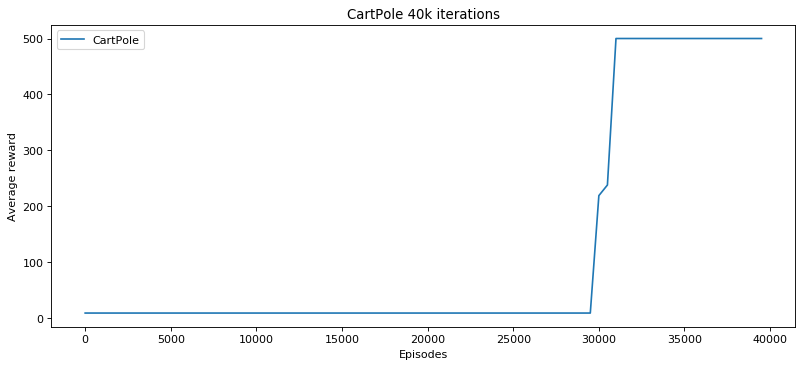

In [24]:
plot_performance([res_cart_pole40k], ['CartPole'], 'CartPole 40k iterations')

In [ ]:
res_frozen60k = run_sarsa('Frozen8', 60000, alpha=0.01, gamma=1, epsilon=0.5, init_type='random', epsilon_decay=True)

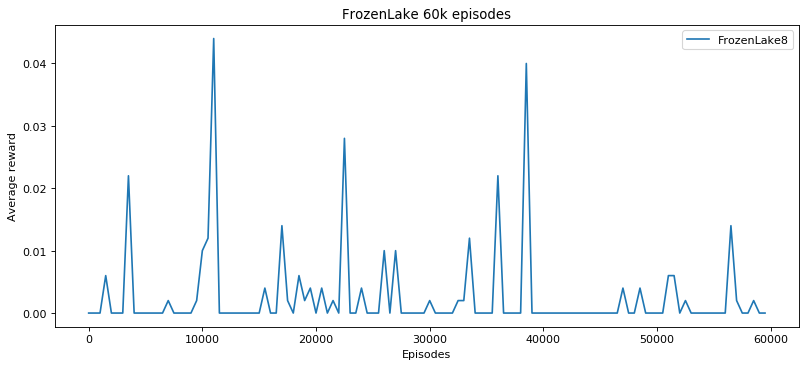

In [15]:
plot_performance([res_frozen60k], ['FrozenLake8'], 'FrozenLake 60k episodes')

In [ ]:
res_lunar40k = run_sarsa('LunarLander', 60000, alpha=0.01, gamma=1, epsilon=0.5, init_type='random', epsilon_decay=True)

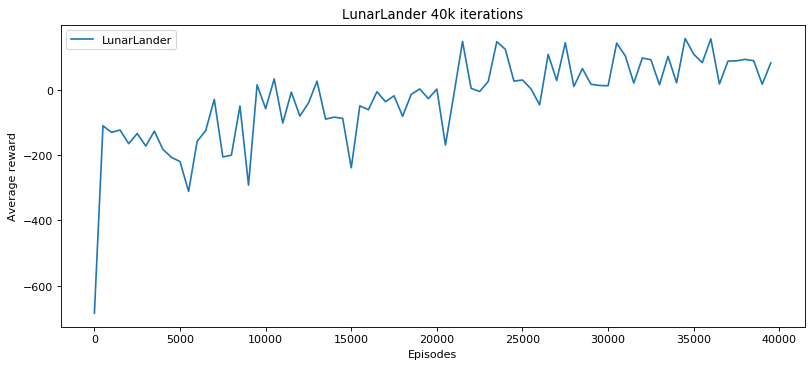

In [13]:
plot_performance([res_lunar40k], ['LunarLander'], 'LunarLander 40k iterations')